# Plotting Resistivity and Siesmic Data

This notebook demonstrates how to extract a smoothed resistivity profile from a ModEM 3D volume, along a 2D seismic line, and plot both the resistivity and seismic data as overlays.

In [1]:
# Add mtpy folder to python path. This may not be necessary 
# depending on how mtpy was installed.
import sys

#sys.path.append('/path/to/mtpy')
sys.path.append('/home/rakib/work/ausLAMP/codes/mtGeoMtpy')

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib import colors
# Import required classes from key mtpy modules 
from mtpy.imaging2.seismic import Segy, VelocityModel
from mtpy.imaging2.modem_slice import MODEM_slice

%matplotlib inline

If you want to write a vtk file for 3d viewing, you need download and install evtk from https://bitbucket.org/pauloh/pyevtk
Note: if you are using Windows you should build evtk first witheither MinGW or cygwin using the command: 
    python setup.py build -compiler=mingw32  or 
    python setup.py build -compiler=cygwin
If you want to write a vtk file for 3d viewing, you need download and install evtk from https://bitbucket.org/pauloh/pyevtk
Note: if you are using Windows you should build evtk first witheither MinGW or cygwin using the command: 
    python setup.py build -compiler=mingw32  or 
    python setup.py build -compiler=cygwin
If you want to write a vtk file for 3d viewing, you need download and install evtk from https://bitbucket.org/pauloh/pyevtk


If you want to write a vtk file for 3d viewing, you need download and install evtk from https://bitbucket.org/pauloh/pyevtk


## Load Seismic Data

* The **Segy** class is used to load 2D segy data
* The **VelocityModel** class is used to create a velocity model based on stacking velocities

In [3]:
segy_fn = '/home/rakib/work/ausLAMP/AlisonPlotting/plotting/seismic/mig_09ga_ga1_20s.sgy'
stacking_velocity_fn = '../data/seismic/stacking_velocities.txt'

sl = Segy(segy_fn)
vm = VelocityModel(stacking_velocity_fn, ni=20)

## Load ModEM Model and Data

The **MODEM_slice** class loads a model and corresponding data file. The model-mesh is centerted on the centre-point of station-locations in the data file.

In [4]:
m_fn = '../data/ModEM_files/Modular_MPI_NLCG_056_im2.rho'
d_fn = '../data/ModEM_files/ModEM_Data_im2.dat'

ms = MODEM_slice(model_fn=m_fn, data_fn=d_fn)

## Fetch Migrated Seismic Profile

Concentration of traces, as a function of distance from the start of the 2D line, may vary, which can lead to plotting artefacts. To avoid such artefacts, we fetch traces at regular intervals along the length of the survey.

In [9]:
PLOT_NTRACE = 1500 # number of traces to be plotted
S_MAX_DEPTH = 60e3 # maximum depth
NDEPTHS = 4000 # number of depth intervals (NDEPTHS), which should be ~ the number of samples in each trace

distances = sl.getDistances() # distance of each trace from the start of the 2D line

# define 1D grids for depth and distance, based on parameters defined above
gdepth    = np.linspace(0, S_MAX_DEPTH, NDEPTHS)
gdistance = np.linspace(0, np.max(distances), PLOT_NTRACE)

# fetch a depth-migrated image (done using velocity model defined earlier)
mdepth, mdist, svals = sl.getMigratedProfile(vm, gdepth, gdistance, time_shift=225, nn=1)

## Fetch Resistivity Profile Along Seismic Line


In [10]:
# retrieve x coordinates of traces fetched above
gx        = np.array([sl.getAttribute('x', d) for d in gdistance])

# retrieve y coordinates of traces fetched above
gy        = np.array([sl.getAttribute('y', d) for d in gdistance])

# since the resistivity model has log-spacing in z, it would be an 
# overkill to sample it as finely as the in the seismic profile -- so, 
# instead, we use the z values in resistivity model
gz        = ms._m.grid_z

# create a list of coordinates that define the profile
mgxyz = []
for z in gz:
    for x,y in zip(gx, gy):
        mgxyz.append([x, y, z])

mgxyz = np.array(mgxyz)

# fetch slice, smoothed using 10 nearest neighbours 
mvals = ms.get_slice(mgxyz, nn=1)

# reshape the resistivity array
mvals = np.reshape(mvals, (gz.shape[0], gx.shape[0]))

## Plot Both Profiles Using Contourf

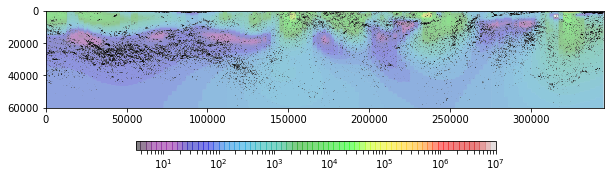

In [11]:
# set plot dimensions
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
fig,ax = plt.subplots(1,1)

# plot resistivity ==================================================
# matplotlib and some viewers have a bug that causes filled contour plots
# to appear as having gaps. To circumvent these issues, we plot the values
# twice, each time with half the intended alpha-value (0.5)
ci = ax.contourf(gdistance, gz, mvals, levels=np.logspace(0.5, 7, 70), 
                 norm=colors.LogNorm(),
                 cmap='nipy_spectral', alpha=0.25, antialiased=True, 
                 rasterized=True, lws=0, ls=None)

ci = ax.contourf(gdistance, gz, mvals, levels=np.logspace(0.5, 7, 70), 
                 norm=colors.LogNorm(),
                 cmap='nipy_spectral', alpha=0.25, antialiased=True, 
                 rasterized=True, lws=0, ls=None)

# plot colorbar. Note that we explicitly set alpha value to 0.5, to account
# for darker colors in the plot that result from calling contourf twice.
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.025])
cb = plt.colorbar(ci, cax=cb_ax, ticks = LogLocator(subs=range(10)), 
                  orientation="horizontal")
cb.solids.set(alpha=0.5)
cb.solids.set_edgecolor('none') 

# set max depth to 60 km, because the resistivity model goes much deeper
M_MAX_DEPTH = 60e3

# Plot seismic ======================================================   
# compute the 99th percentile and zero out all values below that. This can
# be tweaked to plot the required amount of detail without cluttering the
# plot
vmm = np.fabs(np.percentile(svals.flatten(), 99))
svalsClipped = np.array(svals)
svalsClipped[svalsClipped<vmm]=0
ax.contourf(mdist, mdepth, svalsClipped, 50, 
              vmin=-vmm, vmax=vmm,
              cmap='Greys', alpha=0.15)
    
ax.invert_yaxis()
ax.set_aspect(1)
ax.set_ylim(M_MAX_DEPTH) 

plt.savefig('/tmp/b.png', dpi=600)

## Plot Both Profiles Using Pcolor

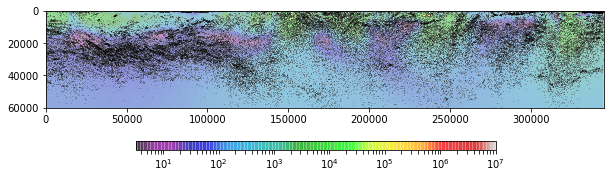

In [8]:
# set plot dimensions
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
fig,ax = plt.subplots(1,1)

# plot resistivity ==================================================
ci = ax.pcolor(gdistance, gz, mvals, 
               norm=colors.LogNorm(),
               vmin=np.power(10,0.5), vmax=np.power(10,7),
               cmap='nipy_spectral', 
               alpha=0.5, linewidth=0, 
               edgecolors='None',
               rasterized=True)

# deal with white stripes
ci.set_antialiaseds(True)
ci.set_rasterized(True)

# plot colorbar. Note that we explicitly set alpha value to 0.5, to account
# for darker colors in the plot that result from calling contourf twice.
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.025])
cb = plt.colorbar(ci, cax=cb_ax, ticks = LogLocator(subs=range(10)), 
                  orientation="horizontal")
cb.solids.set_edgecolor('none') 
cb.solids.set_antialiased(True)
cb.solids.set_rasterized(True) 


# set max depth to 60 km, because the resistivity model goes much deeper
M_MAX_DEPTH = 60e3

# Plot seismic ======================================================   
# compute the 99th percentile and zero out all values below that. This can
# be tweaked to plot the required amount of detail without cluttering the
# plot


vmm = np.percentile(svals.flatten(), 99) 
svalsClipped = np.array(svals)
svalsClipped[svalsClipped<vmm]=0
ci = ax.contourf(mdist, mdepth, svalsClipped, 50, 
                 vmin=-vmm, vmax=vmm,
                 cmap='Greys', alpha=0.15, rasterized=True)
    
ax.invert_yaxis()
ax.set_aspect(1)
ax.set_ylim(M_MAX_DEPTH) 


plt.savefig('/tmp/c.png', dpi=600)